## Introduction 
**We will deeply discuss how we define the cost function and implement solvers through the code**.

### Import Libraries

In [36]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

## Defining the Cost Function
<div style="font-size: 130%;">

We therefore define our cost function as the sum of two main components:
a **position-related** cost and a **direction-related** cost.
</div>

$
\Large
J(\mathbf{p}, \mathbf{n})
\;=\;
J^{\text{pos}}(\mathbf{p})
\;+\;
J^{\text{dir}}(\mathbf{n})
$

<div style="font-size: 130%;">

Since we assume that ground truth trajectory data is unknow, balance between data fidelity and smoothness is very important. \
So we can define our two parts of the **cost** function as also two parts:
</div>

$
\Large
J^{\text{pos}}(\mathbf{p}) \;=\; J^{\text{pos}}_{fidelety} + J^{\text{pos}}_{smoothness}
$\
$
\Large
J^{\text{dir}}(\mathbf{n}) \;=\; J^{\text{dir}}_{fidelety} + J^{\text{dir}}_{smoothness}
$


---

<div style="font-size: 130%;">

Fidelity parts are relatively more intuative to figure out. \
Since we want our cost function to penalty our predictions when it is not close to the original (noisy) data, we can directly use `Sum Square Error` or `Mean Square Error`

</div>


$
\Large
J^{\text{pos}}_{fidelety}(\mathbf{p}) \;=\;
\sum_{i=1}^{N} \|\mathbf{p}_i - \mathbf{y^p}_i\|^2
$\
$
\Large
J^{\text{dir}}_{fidelety}(\mathbf{n}) \;=\;
\sum_{i=1}^{N} \|\mathbf{n}_i - \mathbf{y^n}_i\|^2
$

---


<div style="font-size: 130%;">

To **penalize non-smoothness** in the reconstructed trajectory,  
we can examine the changes in position over discrete time steps.

The **difference** between two consecutive positions approximates the **velocity**: \
$
\Large
\mathbf{v}_i = \mathbf{p}_{i+1} - \mathbf{p}_i
$

Similarly, the **change** in velocity between two steps approximates the **acceleration**: \
$
\Large
\mathbf{a}_i = \mathbf{v}_i - \mathbf{v}_{i-1}
$

Substituting the expressions for velocity, we get: \
$
\Large
\mathbf{a}_i 
= (\mathbf{p}_{i+1} - \mathbf{p}_i) - (\mathbf{p}_i - \mathbf{p}_{i-1})
= \mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}
\;\approx\; \text{acceleration (rate of change of velocity)}.
$
\

Therefore, to **encourage smoothness**, we penalize large accelerations using the following regularization term: \
\
$
\Large
J^{\text{pos}}_{smoothness}(\mathbf{p}) \;=\;
\lambda_{1} \sum_{i=2}^{N-1} \|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2
$\
\
\
Exactly the same for direction, to **encourage smoothness**, \
\
$
\Large
J^{\text{dir}}_{smoothness}(\mathbf{n}) \;=\;
\lambda_{2} \sum_{i=2}^{N-1} \|\mathbf{n}_{i+1} - 2\mathbf{n}_i + \mathbf{n}_{i-1}\|^2
$

---

So here our **cost** function: \
$
\Large
J(\mathbf{p}, \mathbf{n}) \;=\;
\\
\sum_{i=1}^{N} \|\mathbf{p}_i - \mathbf{y^p}_i\|^2
\;+\;
\\
\lambda_{1} \sum_{i=2}^{N-1} \|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2 
\;+\;
\\
\sum_{i=1}^{N} \|\mathbf{n}_i - \mathbf{y^n}_i\|^2
\;+\;
\\
\lambda_{2} \sum_{i=2}^{N-1} \|\mathbf{n}_{i+1} - 2\mathbf{n}_i + \mathbf{n}_{i-1}\|^2 
$
</div>

### Read data

In [37]:
data = np.load('drone_trajectory.npz')
trajectory = data.get('trajectory_noisy')

positions = trajectory[:, :3]  # y^p
nv        = trajectory[:, 3:6] # y^n

In [38]:

def cost_function(p, n, y_p, y_n, lam_1, lam_2):
    # position fidelity
    fidelity_p = torch.sum(torch.norm(p - y_p, dim=1)**2)

    # position smoothness (second difference)
    smooth_p = torch.sum(
        torch.norm(p[2:] - 2*p[1:-1] + p[:-2], dim=1)**2
    )

    # direction fidelity
    fidelity_n = torch.sum(torch.norm(n - y_n, dim=1)**2)

    # direction smoothness
    smooth_n = torch.sum(
        torch.norm(n[2:] - 2*n[1:-1] + n[:-2], dim=1)**2
    )

    return fidelity_p + lam_1 * smooth_p + fidelity_n + lam_2 * smooth_n

<div style="font-size: 130%;">

## Gradient of the Cost Function

$
\Large
\nabla J(\mathbf{p}, \mathbf{n})
\;=\;
\begin{bmatrix} \frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{p}} \\ \frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{n}} \end{bmatrix}
$

$
\Large
\frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{p}}
\;=\;
\frac{\partial J^{\text{pos}}_{fidelety}(\mathbf{p})}{\partial \mathbf{p}}
\;+\;
\frac{\partial J^{\text{dir}}_{fidelety}(\mathbf{n})}{\partial \mathbf{p}}
\;+\;
\frac{\partial J^{\text{pos}}_{smoothness}(\mathbf{p})}{\partial \mathbf{p}}
\;+\;
\frac{\partial J^{\text{dir}}_{smoothness}(\mathbf{n})}{\partial \mathbf{p}}
$


$
\Large
\frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{n}} 
\;=\;
\frac{\partial J^{\text{pos}}_{fidelety}(\mathbf{p})}{\partial \mathbf{n}}
\;+\;
\frac{\partial J^{\text{dir}}_{fidelety}(\mathbf{n})}{\partial \mathbf{n}}
\;+\;
\frac{\partial J^{\text{pos}}_{smoothness}(\mathbf{p})}{\partial \mathbf{n}}
\;+\;
\frac{\partial J^{\text{dir}}_{smoothness}(\mathbf{n})}{\partial \mathbf{n}}
$

Some of them **equals zero** when we get the derivative.

$
\Large
\frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{p}}
\;=\;
\frac{\partial J^{\text{pos}}_{fidelety}(\mathbf{p})}{\partial \mathbf{p}}
\;+\;
\frac{\partial J^{\text{pos}}_{smoothness}(\mathbf{p})}{\partial \mathbf{p}}
$


$
\Large
\frac{\partial J(\mathbf{p}, \mathbf{n})}{\partial \mathbf{n}} 
\;=\;
\frac{\partial J^{\text{dir}}_{fidelety}(\mathbf{n})}{\partial \mathbf{n}}
\;+\;
\frac{\partial J^{\text{dir}}_{smoothness}(\mathbf{n})}{\partial \mathbf{n}}
$

---

### Gradient of Position Fidelity Term

$
\Large
J^{\text{pos}}_{\text{fidelity}}(\mathbf{p}) = \sum_{i=1}^{N} \|\mathbf{p}_i - \mathbf{y}^p_i\|^2
$

Taking the derivative with respect to $\mathbf{p}_i$:

$
\Large
\frac{\partial J^{\text{pos}}_{\text{fidelity}}}{\partial \mathbf{p}_i} = 2(\mathbf{p}_i - \mathbf{y}^p_i)
$

---

### Gradient of Position Smoothness Term

$
\Large
J^{\text{pos}}_{\text{smoothness}}(\mathbf{p}) = \lambda_1 \sum_{i=2}^{N-1} \|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2
$

For each $\mathbf{p}_i$, we need to identify which terms in the sum contain $\mathbf{p}_i$:

- When $i=1$: appears in term $(i=2)$: $\|\mathbf{p}_3 - 2\mathbf{p}_2 + \mathbf{p}_1\|^2$
- When $2 \leq i \leq N-2$: appears in three terms:
  - $(i-1)$: $\|\mathbf{p}_i - 2\mathbf{p}_{i-1} + \mathbf{p}_{i-2}\|^2$ (coefficient: $+1$)
  - $(i)$: $\|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2$ (coefficient: $-2$)
  - $(i+1)$: $\|\mathbf{p}_{i+2} - 2\mathbf{p}_{i+1} + \mathbf{p}_i\|^2$ (coefficient: $+1$)
- When $i=N$: appears in term $(i=N-1)$: $\|\mathbf{p}_N - 2\mathbf{p}_{N-1} + \mathbf{p}_{N-2}\|^2$

Let $\mathbf{d}_i = \mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}$ for $i = 2, \ldots, N-1$.

$
\Large
\frac{\partial J^{\text{pos}}_{\text{smoothness}}}{\partial \mathbf{p}_i} = \begin{cases}
2\lambda_1 \mathbf{d}_2 & i=1 \\
2\lambda_1 (\mathbf{d}_i - 2\mathbf{d}_{i+1} + \mathbf{d}_{i+2}) & 2 \leq i \leq N-2 \\
2\lambda_1 \mathbf{d}_{N-1} & i=N
\end{cases}
$

Or more compactly:

$
\Large
\frac{\partial J^{\text{pos}}_{\text{smoothness}}}{\partial \mathbf{p}_i} = \begin{cases}
2\lambda_1 (\mathbf{p}_3 - 2\mathbf{p}_2 + \mathbf{p}_1) & i=1 \\
2\lambda_1 (\mathbf{p}_{i+2} - 4\mathbf{p}_{i+1} + 6\mathbf{p}_i - 4\mathbf{p}_{i-1} + \mathbf{p}_{i-2}) & 2 \leq i \leq N-2 \\
2\lambda_1 (\mathbf{p}_N - 2\mathbf{p}_{N-1} + \mathbf{p}_{N-2}) & i=N
\end{cases}
$

---

### Complete Gradient with Respect to Position

$
\Large
\frac{\partial J}{\partial \mathbf{p}_i} = 2(\mathbf{p}_i - \mathbf{y}^p_i) + \frac{\partial J^{\text{pos}}_{\text{smoothness}}}{\partial \mathbf{p}_i}
$

---

### Gradient with Respect to Direction (Analogous)

By the same derivation:

$
\Large
\frac{\partial J}{\partial \mathbf{n}_i} = 2(\mathbf{n}_i - \mathbf{y}^n_i) + \frac{\partial J^{\text{dir}}_{\text{smoothness}}}{\partial \mathbf{n}_i}
$

where the smoothness gradient for direction follows the same structure as position.

</div>

In [39]:
def gradient(p, n, y_p, y_n, lam_1, lam_2):
    cost = cost_function(p, n, y_p, y_n, lam_1, lam_2)
    
    # gradients using autograd
    cost.backward()
    
    grad_p = p.grad.clone()
    grad_n = n.grad.clone()
    
    return grad_p, grad_n

In [ ]:
def restore_trajectory(y_p, y_n, lam_1=0.1, lam_2=0.1, 
                       learning_rate=0.01, max_iters=1000, tol=1e-6):
    # Convert to PyTorch tensors
    y_p_tensor = torch.tensor(y_p, dtype=torch.float32)
    y_n_tensor = torch.tensor(y_n, dtype=torch.float32)
    
    # Initialize with noisy observations (requires_grad=True for optimization)
    p = torch.tensor(y_p.copy(), dtype=torch.float32, requires_grad=True)
    n = torch.tensor(y_n.copy(), dtype=torch.float32, requires_grad=True)
    
    costs = []
    
    print("\nStarting gradient descent optimization...")
    
    for iteration in range(max_iters):
        # Compute cost and gradients
        cost_val = cost_function(p, n, y_p_tensor, y_n_tensor, lam_1, lam_2)
        costs.append(cost_val.item())
        
        # Zero gradients from previous iteration
        if p.grad is not None:
            p.grad.zero_()
        if n.grad is not None:
            n.grad.zero_()
        
        # Compute gradients
        grad_p, grad_n = gradient(p, n, y_p_tensor, y_n_tensor, lam_1, lam_2)
        
        # Update parameters (detach and create new tensors with grad enabled)
        with torch.no_grad():
            p_new_data = p - learning_rate * grad_p
            n_new_data = n - learning_rate * grad_n
        
        p = p_new_data.clone().detach().requires_grad_(True)
        n = n_new_data.clone().detach().requires_grad_(True)
        
        # Check convergence
        if iteration > 0 and abs(costs[-1] - costs[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break
        
        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration + 1}/{max_iters}, Cost: {cost_val.item():.6f}")
    
    print(f"Final cost: {costs[-1]:.6f}")
    
    # Convert back to numpy
    p_restored = p.detach().numpy()
    n_restored = n.detach().numpy()
    
    return p_restored, n_restored, costs


## Plot the restored trajectory

In [44]:
def plot_trajectory_with_directions(trajectory: np.array, label: str):
    ax = plt.figure().add_subplot(projection='3d')

    x, y, z = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]
    nv = trajectory[:, 3:6]

    ax.plot(x, y, z, label=label, color='blue')

    # plot direction vectors
    # plot every Nth vector
    N = 10
    ax.quiver(
        x[::N], y[::N], z[::N],                 # start positions
        nv[::N, 0], nv[::N, 1], nv[::N, 2],     # vector directions
        length=1.0, normalize=True, color='red'
    )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()


Starting gradient descent optimization...
Iteration 100/2000, Cost: 4.571118
Converged at iteration 147
Final cost: 4.570699

=== Results ===

Noisy trajectory errors:
  Mean position error: 0.123510
  Mean direction error: 0.131192

Restored trajectory errors:
  Mean position error: 0.066177
  Mean direction error: 0.072855

Improvement:
  Position error reduction: 46.42%
  Direction error reduction: 44.47%

Step 5: Generating visualizations...


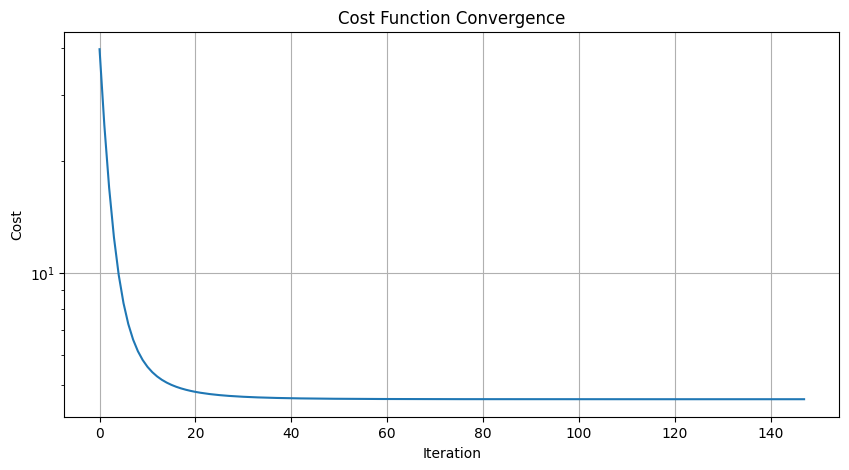

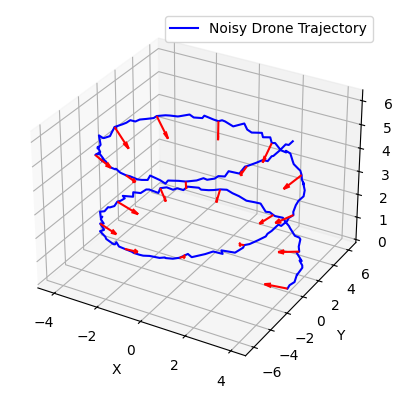

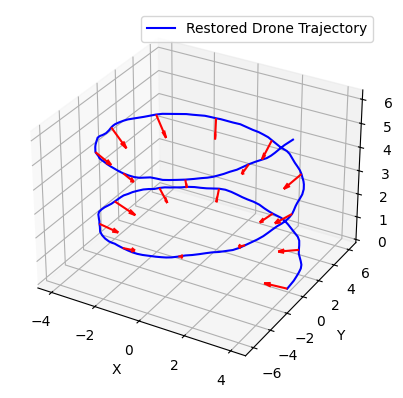

In [46]:
# load trajectory from .npz
data = np.load('drone_trajectory.npz')
trajectory_original = data.get('trajectory')
trajectory_noisy = data.get('trajectory_noisy')
positions = trajectory_noisy[:, :3]
nv = trajectory_noisy[:, 3:6]  # direction vectors
y_p = trajectory_noisy[:, :3]  # noisy positions
y_n = trajectory_noisy[:, 3:]  # noisy directions

p = y_p.copy()  # initial guess
n = y_n.copy()

lam_1 = 1.1
lam_2 = 0.8

p_restored, n_restored, costs = restore_trajectory(
        y_p, y_n, 
        lam_1=lam_1, 
        lam_2=lam_2,
        learning_rate=0.01,
        max_iters=2000,
        tol=1e-6
    )

# Combine restored positions and directions
trajectory_restored = np.hstack([p_restored, n_restored])

# Calculate errors
position_error = np.mean(np.linalg.norm(p_restored - trajectory_original[:, :3], axis=1))
direction_error = np.mean(np.linalg.norm(n_restored - trajectory_original[:, 3:], axis=1))

position_error_noisy = np.mean(np.linalg.norm(y_p - trajectory_original[:, :3], axis=1))
direction_error_noisy = np.mean(np.linalg.norm(y_n - trajectory_original[:, 3:], axis=1))

print(f"\n=== Results ===")
print(f"\nNoisy trajectory errors:")
print(f"  Mean position error: {position_error_noisy:.6f}")
print(f"  Mean direction error: {direction_error_noisy:.6f}")
print(f"\nRestored trajectory errors:")
print(f"  Mean position error: {position_error:.6f}")
print(f"  Mean direction error: {direction_error:.6f}")
print(f"\nImprovement:")
print(f"  Position error reduction: {(1 - position_error/position_error_noisy)*100:.2f}%")
print(f"  Direction error reduction: {(1 - direction_error/direction_error_noisy)*100:.2f}%")

# Plot cost convergence
print("\nStep 5: Generating visualizations...")
plt.figure(figsize=(10, 5))
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.grid(True)
plt.yscale('log')
plt.show()

# Plot comparison
# plot_comparison(trajectory_original, trajectory_noisy, trajectory_restored)

# Plot restored trajectory
# plot_trajectory_with_directions(trajectory_original, "Ground Truth Drone Trajectory")
plot_trajectory_with_directions(trajectory_noisy, "Noisy Drone Trajectory")
plot_trajectory_with_directions(trajectory_restored, "Restored Drone Trajectory")

## Line Search Methods

Line search methods are iterative optimization algorithms that follow this general pattern:

$
\Large
\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha \mathbf{d}_k
$

where:
- $\mathbf{x}_k$ is the current iterate
- $\alpha > 0$ is a **constant step size** (learning rate)
- $\mathbf{d}_k$ is the search direction

---

### First-Order Method: Gradient Descent

The search direction is the **negative gradient**:

$
\Large
\mathbf{d}_k = -\nabla J(\mathbf{x}_k)
$

This direction guarantees descent because:

$
\Large
\nabla J(\mathbf{x}_k)^T \mathbf{d}_k = -\|\nabla J(\mathbf{x}_k)\|^2 < 0
$

**Update rule:**

$
\Large
\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha \nabla J(\mathbf{x}_k)
$

The step size $\alpha$ must be chosen carefully:
- Too large: overshooting, divergence
- Too small: slow convergence

---

### Second-Order Method: Newton's Method

The search direction uses **second-order information** (Hessian):

$
\Large
\mathbf{d}_k = -\mathbf{H}_k^{-1} \nabla J(\mathbf{x}_k)
$

where $\mathbf{H}_k = \nabla^2 J(\mathbf{x}_k)$ is the Hessian matrix.

**Update rule:**

$
\Large
\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha \mathbf{H}_k^{-1} \nabla J(\mathbf{x}_k)
$

Newton's method has **quadratic convergence** near the minimum when $\mathbf{H}_k$ is positive definite.

For our problem, we typically use $\alpha = 1.0$ for Newton's method since the Hessian already provides optimal scaling.

---
## Hessian Matrix of the Cost Function

The Hessian matrix contains all second-order partial derivatives:

$
\Large
\mathbf{H} = \nabla^2 J(\mathbf{p}, \mathbf{n}) = 
\begin{bmatrix}
\frac{\partial^2 J}{\partial \mathbf{p} \partial \mathbf{p}} & \frac{\partial^2 J}{\partial \mathbf{p} \partial \mathbf{n}} \\
\frac{\partial^2 J}{\partial \mathbf{n} \partial \mathbf{p}} & \frac{\partial^2 J}{\partial \mathbf{n} \partial \mathbf{n}}
\end{bmatrix}
$

Since $J(\mathbf{p}, \mathbf{n})$ separates into independent position and direction terms:

$
\Large
\mathbf{H} = 
\begin{bmatrix}
\mathbf{H}_{\mathbf{p}} & \mathbf{0} \\
\mathbf{0} & \mathbf{H}_{\mathbf{n}}
\end{bmatrix}
$

where $\frac{\partial^2 J}{\partial \mathbf{p} \partial \mathbf{n}} = \mathbf{0}$ (positions and directions are decoupled).

---

### Hessian of Position Terms

$
\Large
\mathbf{H}_{\mathbf{p}} = \frac{\partial^2 J}{\partial \mathbf{p}^2} = \frac{\partial^2 J^{\text{pos}}_{\text{fidelity}}}{\partial \mathbf{p}^2} + \frac{\partial^2 J^{\text{pos}}_{\text{smoothness}}}{\partial \mathbf{p}^2}
$

**Hessian of Fidelity Term:**

$
\Large
J^{\text{pos}}_{\text{fidelity}} = \sum_{i=1}^{N} \|\mathbf{p}_i - \mathbf{y}^p_i\|^2
$

The second derivative gives:

$
\Large
\frac{\partial^2 J^{\text{pos}}_{\text{fidelity}}}{\partial \mathbf{p}_i \partial \mathbf{p}_j} = \begin{cases}
2\mathbf{I}_{3 \times 3} & i = j \\
\mathbf{0}_{3 \times 3} & i \neq j
\end{cases}
$

This contributes $2\mathbf{I}$ to the diagonal blocks.

---

**Hessian of Smoothness Term:**

$
\Large
J^{\text{pos}}_{\text{smoothness}} = \lambda_1 \sum_{i=2}^{N-1} \|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2
$

For a single term $\|\mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}\|^2$, the Hessian has a **pentadiagonal structure**.

Let's compute: $\mathbf{d}_i = \mathbf{p}_{i+1} - 2\mathbf{p}_i + \mathbf{p}_{i-1}$

$
\Large
\|\mathbf{d}_i\|^2 = \mathbf{d}_i^T \mathbf{d}_i
$

The second derivatives are:

$
\Large
\frac{\partial^2 \|\mathbf{d}_i\|^2}{\partial \mathbf{p}_j \partial \mathbf{p}_k} = 
\begin{cases}
2 \cdot 1 \cdot \mathbf{I} = 2\mathbf{I} & (j,k) = (i-1, i-1) \text{ or } (i+1, i+1) \\
2 \cdot 4 \cdot \mathbf{I} = 8\mathbf{I} & (j,k) = (i, i) \\
2 \cdot (-2) \cdot \mathbf{I} = -4\mathbf{I} & (j,k) \in \{(i-1,i), (i,i-1), (i,i+1), (i+1,i)\} \\
2 \cdot 1 \cdot \mathbf{I} = 2\mathbf{I} & (j,k) \in \{(i-1,i+1), (i+1,i-1)\} \\
\mathbf{0} & \text{otherwise}
\end{cases}
$

**Structure of $\mathbf{H}_{\mathbf{p}}$:**

The Hessian is a **block pentadiagonal matrix** where each block is $3 \times 3$:

$
\Large
\mathbf{H}_{\mathbf{p}} = 2\mathbf{I} + 2\lambda_1
\begin{bmatrix}
\mathbf{A}_1 & \mathbf{B}_1 & \mathbf{C}_1 & & & \\
\mathbf{B}_1^T & \mathbf{A}_2 & \mathbf{B}_2 & \mathbf{C}_2 & & \\
\mathbf{C}_1^T & \mathbf{B}_2^T & \mathbf{A}_3 & \mathbf{B}_3 & \ddots & \\
& \mathbf{C}_2^T & \ddots & \ddots & \ddots & \mathbf{C}_{N-3} \\
& & \ddots & \mathbf{B}_{N-2}^T & \mathbf{A}_{N-1} & \mathbf{B}_{N-1} \\
& & & \mathbf{C}_{N-3}^T & \mathbf{B}_{N-1}^T & \mathbf{A}_N
\end{bmatrix}
$

where the diagonal blocks are:
- $\mathbf{A}_1 = \mathbf{I}$ (boundary)
- $\mathbf{A}_i = 6\mathbf{I}$ for $2 \leq i \leq N-1$ (interior)
- $\mathbf{A}_N = \mathbf{I}$ (boundary)

and off-diagonal blocks:
- $\mathbf{B}_i = -4\mathbf{I}$ (adjacent interactions)
- $\mathbf{C}_i = \mathbf{I}$ (two-step interactions)

---

### Hessian of Direction Terms

By symmetry:

$
\Large
\mathbf{H}_{\mathbf{n}} = 2\mathbf{I} + 2\lambda_2 \cdot [\text{same pentadiagonal structure}]
$

---

### Properties of the Hessian

1. **Symmetric**: $\mathbf{H}^T = \mathbf{H}$
2. **Block-diagonal**: Position and direction terms are decoupled
3. **Sparse**: Pentadiagonal structure (only 5 diagonals have non-zero blocks)
4. **Positive definite** when $\lambda_1, \lambda_2 > 0$: guarantees a unique global minimum

</div>